In [50]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.io.wavfile
from scipy.interpolate import interp1d
from scipy.signal import correlate
from itertools import combinations

# Microphone and correlation function definition
The `Microphone` class below provides some convenience functions for working with placed microphones

In [51]:
c_sound = 343
class Microphone:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    def arrival_time(self, x, y):
        return np.sqrt((x - self.x)**2 + (y - self.y)**2) / c_sound
      
def correlation_fn(mic1, mic2, f1, f2, sample_rate):
    c = correlate(f1, f2, 'full', 'fft')
    
    # the spacing of the microphones and speed of sound determines the maximum possible 
    # time difference between signals. 0.9 factor is a safety factor 
    max_t_diff = np.sqrt((mic1.x - mic2.x)**2 + (mic1.y - mic2.y)**2) / (0.9*c_sound)
    
    n_samples = len(f1)
    dt = 1/sample_rate
    
    t = np.arange(-n_samples+1, n_samples)*dt
    mask = (t > -max_t_diff) & (t < max_t_diff)
    
    # only create an interpolant on the relevant region
    fn = interp1d(t[mask], c[mask], kind='cubic')
    
    def corr(x, y):
        dt = mic1.arrival_time(x, y) - mic2.arrival_time(x, y)
        return fn(dt)
    
    return corr

def create_objective(mics, data, sample_rate):
    c_funcs = []
    n_channels = data.shape[1]
    
    # Create a correlation function for each pair of microphones
    for pair in combinations(range(n_channels), 2):
        i1, i2 = pair
        c_funcs.append(correlation_fn(mics[i1], mics[i2], data[:, i1], data[:, i2], sample_rate))

    def objective(X, Y):
        return sum(cf(X, Y) for cf in c_funcs)
    
    return objective

# Set up microphone positions to correspond to DOC trial

In [52]:
mic_coords = np.array([[0, 0.375], [0.375, 0], [0, -0.375], [-0.375, 0]])

mics = [Microphone(m[0], m[1]) for m in mic_coords]

# Synthetic signal generation for testing

In [39]:
def generate_synthetic_data(mics, source_position, fname='highsampletext.wav'):
    sample_rate, original = scipy.io.wavfile.read('highsampletext.wav')
    dt = 1/sample_rate
    original = original.astype("float")
    original = original/original.std()
    n_samples = len(original)
    n_channels = 4

    # Compute delays, and make them relative
    delays = [m.arrival_time(source_position[0], source_position[1]) for m in mics]
    delays -= min(delays)

    # Create interpolant
    ts = dt*np.arange(len(original))
    foo = interp1d(ts, original, kind='cubic', fill_value=0.0, bounds_error=False)

    # Create four channel array (like what would be loaded from wav file)
    data = np.zeros((n_samples, 4))
    for i in range(n_channels):
        data[:, i] = foo(ts - delays[i])
    
    return data, sample_rate

# Experiment using doc data
## Load and visualise

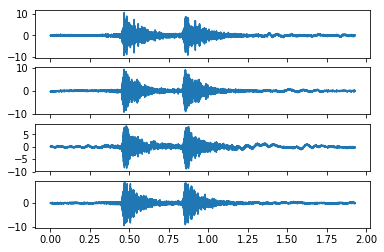

In [53]:
datafile = "onecheep.wav"

sample_rate, data = scipy.io.wavfile.read(datafile)
dt = 1/sample_rate
data = data.astype("float")
n_samples, n_channels = data.shape
fig, ax = plt.subplots(4, 1, sharex='all')
for i in range(n_channels):
    data[:, i] /= data[:, i].std()
    ax[i].plot(np.arange(n_samples)*dt, data[:, i])
    
objfun = create_objective(mics, data, sample_rate)

# Plot heatmap of best guess of bird position
This should work after either running the synthetic data block or after running the DOC data block

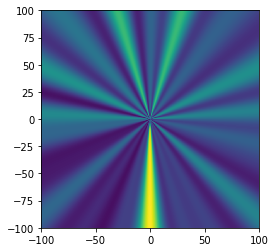

In [55]:
xmin, xmax = -100, 100
ymin, ymax = -100, 100
x = np.linspace(xmin, xmax, 1000)
y = np.linspace(ymin, ymax, 1000)
X, Y = np.meshgrid(x, y)

plt.imshow(objfun(X, Y), extent=(xmin, xmax, ymin, ymax), origin='lower')

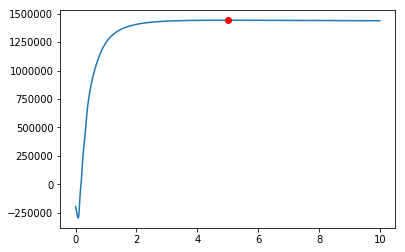

In [56]:
# Define source position
theta = np.pi/8
dist = 5
source_x, source_y = (dist*np.cos(theta), dist*np.sin(theta))

# Create synthetic data based on this position
data, sample_rate = generate_synthetic_data(mics, (source_x, source_y))

objfun = create_objective(mics, data, sample_rate)

# Plot objective along a ray from the origin through the source position
d = np.linspace(0, 10, 1000)
x = d*np.cos(theta)
y = d*np.sin(theta)
plt.plot(d, objfun(x, y))
plt.plot(dist, objfun(source_x, source_y), 'ro')

In [ ]:
data.shape